In [141]:
%matplotlib inline

import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import truncnorm, describe
from scipy.optimize import minimize_scalar, root_scalar

# Signal-in-white-noise model: distributed adaptive method using a surrogate marginal likelihood (Jordan '16)

## Distributed dataset

In [207]:
N = 300 # number of observed coefficients
tau = 1 # scale of the prior
n = 10**5 # size of the dataset
m = 10 # number of machines
beta = 1 # smoothness of the parameters
sigma = 1
alpha = 1 # smoothness of the prior

Text(0,0.5,'Fourier coefficients')

<Figure size 432x288 with 0 Axes>

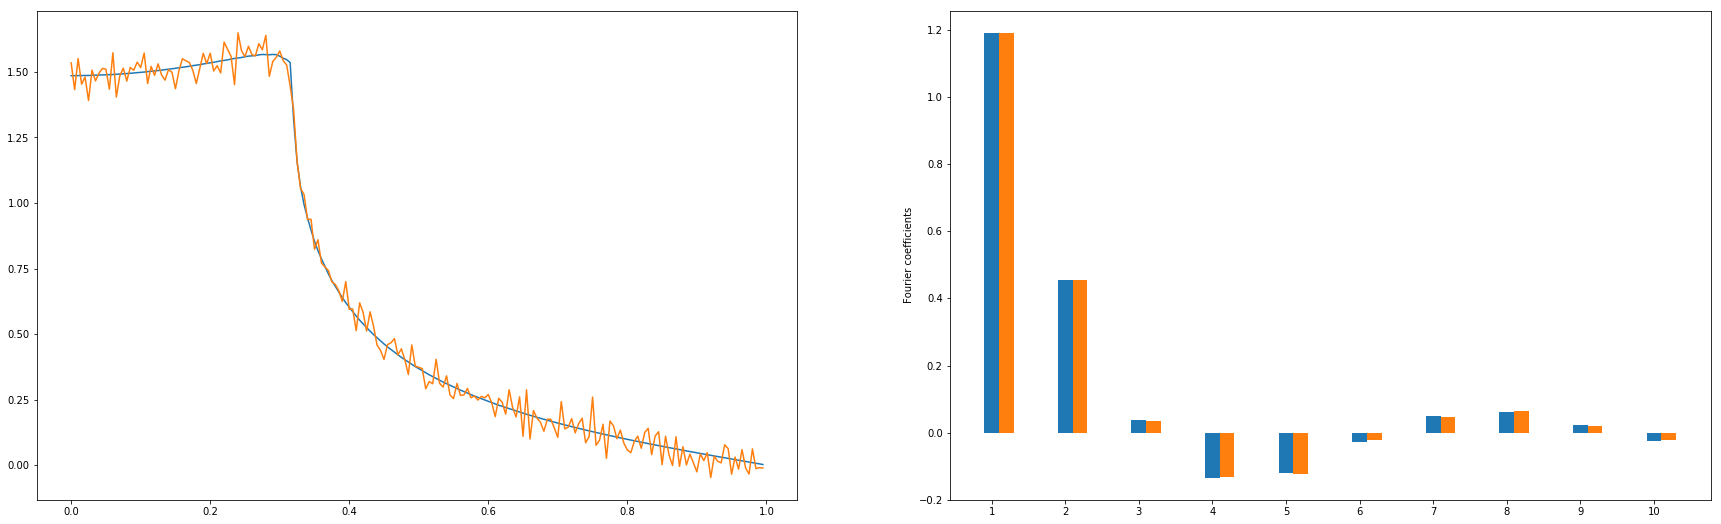

In [208]:
theta = np.sin(np.arange(1.0,N+1.0,1.0)) * np.sqrt(2) / (np.arange(1.0,N+1.0,1.0)) ** 1.5
data = np.tile(theta, (m,1)) + np.random.normal(scale=sigma*np.sqrt(m / n),size=(m,N))

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.005)
Y = [np.sum(theta * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_n = [np.sum(np.mean(data,axis=0) * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_n)

a = ax[1]
index = np.arange(1,11,1)
bar_width = 0.2
opacity = 1
a.bar(index, theta[:10], bar_width, align='center', alpha=opacity)
a.bar(index + bar_width, np.mean(data,axis=0)[:10], bar_width, align='center', alpha=opacity)
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')

## Estimation of $\alpha$

We want to find:
$$ \hat{\alpha} = \arg \max_{\alpha} \log \int_{\theta} \Pi_{j = 1}^{m} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$

Let's call 
$$\mathcal{L}_m(\alpha) =  \log \int_{\theta} \Pi_{j = 1}^{m} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$ the log global marginal likelihood function and
$$\mathcal{L}_j(\alpha) =  \log \int_{\theta} p(Y^j | \theta) \pi(\theta | \alpha) d\theta$$
the local one on node $j$

Inspired by Jordan et al.'s work, we can write a surrogate marginal likelihood function as follows:
$$ \tilde{\mathcal{L}}(\alpha) = \mathcal{L}_1(\alpha) - \alpha \times (\mathcal{L}_1'(\bar\alpha) - \mathcal{L}_m'(\bar\alpha))$$
where $\bar\alpha$ is an initial estimator, for example $ \bar{\alpha} = \arg \max_{\alpha} \mathcal{L}_1(\alpha)$

In our setting with a Gaussian prior $\theta | \alpha \sim \mathcal N(0,\tau i^{-1-2\alpha})$ and a Gaussian local likelihood  $Y^j_i | \theta_i \sim \mathcal N(\theta_i,\sigma^2m/n)$, the local log marginal likelihood has a closed form:
$$ \mathcal{L}_1(\alpha) = \int_{\theta} \Pi_{i=1}^{\infty} p(Y_i^j | \theta_i) \pi(\theta_i | \alpha) d\theta_i $$
$$ \mathcal{L}_1(\alpha) = \log \sum_{i=1}^{\infty} \int_{-\infty}^{+\infty} p(Y_i^j | \theta_i) \pi(\theta_i | \alpha) d\theta_i $$
$$ \mathcal{L}_1(\alpha) = \log \sum_{i=1}^{\infty} \mathcal{L}^i_1(\alpha)$$
and $$ \mathcal{L}^i_1(\alpha) = -\frac 1 2 \frac{{Y_i^1}^2}{\frac{\sigma^2 m}n + \frac{\tau}{i^{1+2\alpha}}} -\frac 1 2 \log (2\pi (\frac{\sigma^2 m}n + \frac{\tau}{i^{1+2\alpha}})) $$

The derivative of the local surrogate marginals also have a closed form and we can approximate the derivative of the global marginal likelihood at the initial point using Deseingrot and Ng (2015) technique:
$$ \mathcal{L}'_m(\bar\alpha) \approx \frac 1 m \sum_{j=1}^{m} \mathcal{L}'_j(\bar\alpha) $$
with $$  \mathcal{L}'_j(\alpha) = \sum_{i=1}^{\infty} \frac{\log i}{1 + \frac{\sigma^2 m i^{1+2\alpha}}{\tau n}} (1 - \frac{{Y_i^j}^2}{\frac{\sigma^2 m}n + \frac{\tau}{i^{1+2\alpha}}}) $$



## Local marginal likelihoods

In [210]:
# Local marginal likelihood

def local_marg_ll(data, j, alpha):
    
    m = data.shape[0]
    l_j = np.sum(- 0.5 * data[j,:]**2 / (sigma**2 *m/n + tau/np.arange(1,N+1)**(1+2*alpha))
                 - 0.5 * np.log(2*np.pi*(sigma**2 *m/n + tau/np.arange(1,N+1)**(1+2*alpha))))
    
    return l_j


In [211]:
# Find the maximum of the marginal likelihood on the first machine for the initial estimator

optim = minimize_scalar(lambda x: -local_marg_ll(data,0,x), bounds=(0.01,5)) 

alpha_bar = optim.x

Text(0.5,1,'Local marginal likelihood for the first 5 machines')

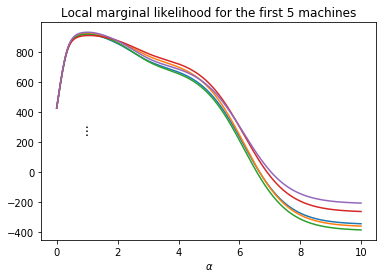

In [212]:
X = np.arange(0,10,0.01)
Y = [[local_marg_ll(data,j,x) for x in X] for j in range(5)]

plt.figure()

for j in range(5):
    plt.plot(X,Y[j])
plt.vlines(x=alpha_bar, ymin=240, ymax=320, linestyle="dotted")
plt.xlabel(r"$\alpha$")
plt.title("Local marginal likelihood for the first 5 machines")

In [213]:
# Derivative function of the local marginals

def deriv_slocal_marg(data, j, alpha):
    
    m = data.shape[0]
    
    l_j = np.sum(np.log(np.arange(1,N+1))
                 / (1 + sigma**2 *m*np.arange(1,N+1)**(1+2*alpha) / (n * tau)) *
                 (1 - data[j,:]**2 / (sigma**2 *m/n + tau/np.arange(1,N+1)**(1+2*alpha))))
    
    return l_j


Text(0.5,1,'Derivative of the local marginal likelihood for the first 5 machines')

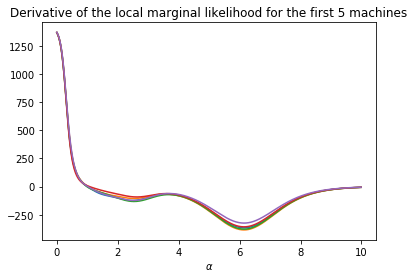

In [214]:
X = np.arange(0,10,0.01)
Y = [[deriv_slocal_marg(data,j,x) for x in X] for j in range(5)]

plt.figure()

for j in range(5):
    plt.plot(X,Y[j])
plt.xlabel(r"$\alpha$")
plt.title("Derivative of the local marginal likelihood for the first 5 machines")

## Surrogate global marginal likelihood and maximization 

In [215]:
# Surrogate global marginal likelihood

def surrogate_global(data, alpha):
    
    m = data.shape[0]
    optim = minimize_scalar(lambda x: -local_marg_ll(data,0,x), bounds=(0.01,5)) 
    alpha_bar = optim.x
    compensator = deriv_surrogate_marg(data, 0, alpha_bar) 
    - sum([deriv_surrogate_marg(data, j, alpha_bar) for j in range(m)])/m

    l = local_marg_ll(data,0,alpha) - alpha*compensator
    
    return l



In [216]:
# Find the maxinmum of the surrogate global marginal likelihood

optim = minimize_scalar(lambda x: -surrogate_global(data,x), bounds=(0.01,5)) 

alpha_hat = optim.x

Text(0.5,1,'Surrogate global likelihood')

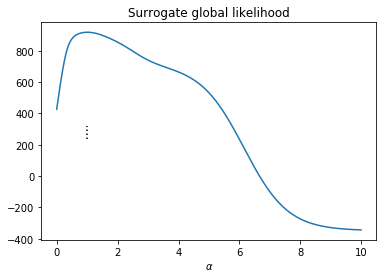

In [217]:
X = np.arange(0,10,0.01)
Y = [surrogate_global(data,x,) for x in X] 

plt.figure()
plt.plot(X,Y)
plt.vlines(x=alpha_hat, ymin=240, ymax=320, linestyle="dotted")
plt.xlabel(r"$\alpha$")
plt.title("Surrogate global likelihood")

In [218]:
alpha_hat

1.0065345193787698

In [219]:
alpha_bar

1.0065345457080506

In [220]:
optim = minimize_scalar(lambda x: -sum([local_marg_ll(data,j,x) for j in range(m)]), bounds=(0.01,5)) 

alpha_sum = optim.x
alpha_sum

1.0228909204440304

The method seems to give a good approximation of the true value $\alpha = 1$, but not as close as the simple maximum of the sum...

In [221]:
S = 100 # number of simulated signals

alpha_hat = np.zeros(S)
alpha_sum = np.zeros(S)

for s in range(S):
    
    data = np.tile(theta, (m,1)) + np.sqrt(sigma * m / n) * np.random.normal(size=(m,N))
    alpha_bar = minimize_scalar(lambda x: -local_marg_ll(data,0,x), bounds=(0.01,5)).x 
    compensator = deriv_surrogate_marg(data, 0, alpha_bar) 
    - sum([deriv_surrogate_marg(data, j, alpha_bar) for j in range(m)])/m
    alpha_hat[s] = minimize_scalar(lambda x: -surrogate_global(data,x), bounds=(0.01,5)).x
    alpha_sum[s] = minimize_scalar(lambda x: -sum([local_marg_ll(data,j,x) for j in range(m)]), bounds=(0.01,5)).x

    

In [222]:
describe(alpha_hat)

DescribeResult(nobs=100, minmax=(0.8104931691877593, 1.1314052770085188), mean=0.9947387598766083, variance=0.003101044527890429, skewness=-0.30192988675325727, kurtosis=0.3444745864270802)

In [223]:
describe(alpha_sum)

DescribeResult(nobs=100, minmax=(0.9615215159683378, 1.050321477081676), mean=1.000157391101328, variance=0.0003387845448473763, skewness=0.38681628753449726, kurtosis=-0.010244988909218211)

In [225]:
ratio = np.array([2,10,10**2,10**3,10**4,10**5])
K = ratio.shape[0]
alpha_hat = np.zeros((K,S))
alpha_sum = np.zeros((K,S))

for k in range(K):
    
    for s in range(S):
    
        data = np.tile(theta, (m,1)) + np.sqrt(sigma * m / n) * np.random.normal(size=(m,N))
        alpha_bar = minimize_scalar(lambda x: -local_marg_ll(data,0,x), bounds=(0.01,5)).x 
        compensator = deriv_surrogate_marg(data, 0, alpha_bar) 
        - sum([deriv_surrogate_marg(data, j, alpha_bar) for j in range(m)])/m
        alpha_hat[k,s] = minimize_scalar(lambda x: -surrogate_global(data,x), bounds=(0.01,5)).x
        alpha_sum[k,s] = minimize_scalar(lambda x: -sum([local_marg_ll(data,j,x) for j in range(m)]), bounds=(0.01,5)).x
